# Τεχνικές Εξόρυξης Δεδομένων
## Εργασία 1 Εαρινό εξάμηνο 2018-2019
### Sentiment Analysis
Καλογερόπουλος Ιωάννης 1115201500057 Παπασωτηρίου Ηλίας 1115201500123

In [35]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'show/hide code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

Save locations of train, test and gold data

In [2]:
from pandas import DataFrame, read_csv
import pandas as pd
import matplotlib.pyplot as plt
import nltk

Location = r'../twitter_data/train2017.tsv'
df = pd.read_csv(Location,delimiter = '\t',nrows=1000,names=['id','id2','tag','text'])

Location_test = r'../twitter_data/test2017.tsv'
df_test = pd.read_csv(Location_test,delimiter = '\t',nrows=1000,names=['id','id2','tag','text'])

Location_corrects = r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'
df_corrects = pd.read_csv(Location_corrects,delimiter = '\t',nrows=1000,names=['id','tag'])

Initializing stemmer and lemmatizer, get_wordnet_pos defined

In [3]:
from bs4 import BeautifulSoup
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import StemmerI, RegexpStemmer, LancasterStemmer, ISRIStemmer, PorterStemmer, SnowballStemmer, RSLPStemmer
from string import punctuation
from nltk.stem import  WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

stemmer = PorterStemmer()
hide_toggle()

clean_text function: Για δεδομένο tweet διαγράφει τα html tags, τις αναφορές (@...), τους αριθμούς, τα urls όπως και αν αρχίζουν και οποιοδήποτε σύμβολο. Μετά το tokenization, την διαδικασία του stemmin και του lemmatizing αφαιρούνται τα stopwords και τα tokens ενώνονται σε ένα string

In [4]:
import nltk

def clean_text(tweet):
    tweet = tweet.lower() 
    tweet = BeautifulSoup(tweet,'lxml').get_text() #remove html tags
    tweet = re.sub(r"@\w+", "",tweet) # Remove twitter handle
    tweet = re.sub(r"\d", "",tweet)   # Remove numbers 
    tweet = re.sub(r"_+", "",tweet)   # Remove consecutive underscores
    tweet = re.sub('www.?[A-Za-z0-9./]+','',tweet) #remove urls
    tweet = re.sub('http?[A-Za-z0-9./]+','',tweet) #start with http
    tweet = re.sub("[^a-zA-Z]", " ", tweet) #keep only letters
    tokens = word_tokenize(tweet)
    stems = [  stemmer.stem(token) for token in tokens ]
    lemms = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in stems]
    filtered = [w for w in lemms if not w in stopwords.words('english')]
    tweet = ' '.join(filtered) #concatenate tokens in list
    return tweet
hide_toggle()

clean train data

In [5]:
clean_tweets = df.text.apply(clean_text)

In [6]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
hide_toggle()

Workcloud presentation

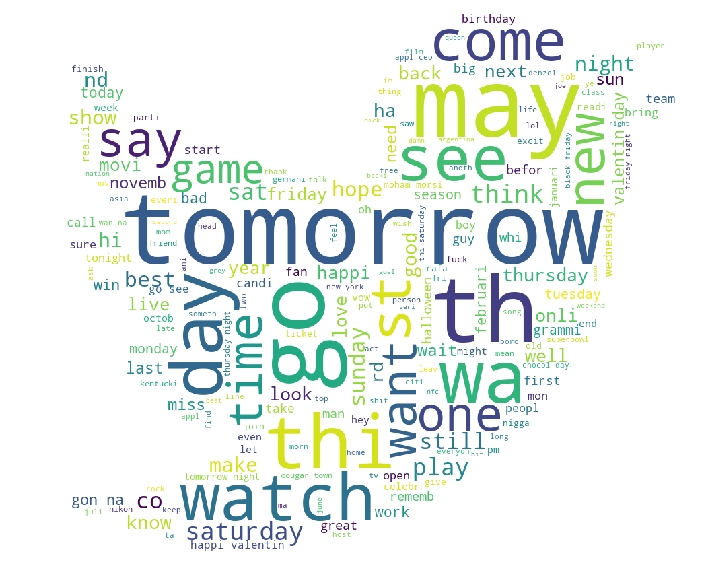

In [7]:
import imageio
from scipy.misc import imread

twitter_mask = imageio.imread('./twitter_mask.png')


wordcloud = WordCloud(
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask).generate(clean_tweets.to_string())
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./t.png', dpi=300)
plt.show()

clean test data

In [8]:
clean_tweets_test = df_test.text.apply(clean_text)

lexica function: για σύνολο από tweets δημιουργεί ένα metadara array το καθένα περιέχοντας τα κατάλληλα στοιχεία που προκύπτουν από την επξεργασία των λέξεών του από τα λεξικά. Τέτοια δεδομένα είναι το πλήθος των λεξεων

In [9]:
import random

def lexica(text):
    Location_lex = r'../lexica/affin/affin.txt'
    mydict = {}
    with open(Location_lex) as f: #saved in dictionary
        for line in f:
            if len(line.split()) == 2:
                (key,value) = line.split()
                mydict[key] = value
    metadata = []
    for tweet in text:
        arr = [] #stores the value for every wot foun in the tweet
        tmp = []
        tmp.append(len(tweet.split())) #length of the tweet
        for word in tweet.split():
            if word in mydict:
                arr.append(float(mydict[word]))
        if arr: #if not empty
            tmp.append(min(arr)) #min value
            if min(arr) == max(arr):
                ran = random.randint(-3,3)
                tmp.append(ran)
                tmp.append(((ran+min(arr))/ 2))  
            else:
                tmp.append(max(arr)) #max value
                tmp.append(float(sum(arr) / len(arr)))  #
        else:
            ran1 = random.randint(-3,3)
            ran2 = random.randint(-3,3)
            tmp.append(ran1)
            tmp.append(ran2)
            tmp.append(((ran1+ran2) / 2))  

        metadata.append(tmp)
    return metadata
hide_toggle()

# KNN
initializing Classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

## Bag-of-words
fit transform for train and test

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import sys
import numpy

numpy.set_printoptions(threshold=sys.maxsize)
bow_vectorizer = CountVectorizer( max_df=1.0,min_df=1,max_features=300, stop_words='english')

bow_xtrain = bow_vectorizer.fit_transform(clean_tweets)

bow_xtest = bow_vectorizer.fit_transform(clean_tweets_test)

adding our metadata to vector

In [12]:
metadata_train = lexica(df.text)
metadata_test = lexica(df_test.text)
arr_train = []
arr_test = []
for vect in zip(bow_xtrain.toarray(),np.array(metadata_train)): 
    arr_train.append(np.append(vect[0],vect[1]))
for vect in zip(bow_xtest.toarray(),np.array(metadata_test)): 
    arr_test.append(np.append(vect[0],vect[1]))

training the classifier

In [13]:
Y = df.tag
knn.fit(arr_train , Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

prediction

In [14]:
result = knn.predict(arr_test)
from sklearn import metrics
result_bag_knn = metrics.accuracy_score(result, df_corrects.tag)
print('Bag-of-words knn: ',result_bag_knn)

Bag-of-words knn:  0.429


## Tf-idf

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer( max_features=300, stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(clean_tweets)

tfidf_test = tfidf_vectorizer.fit_transform(clean_tweets_test)

In [16]:
arr_train_tfi = []
arr_test_tfi = []
for vect in zip(tfidf_train.toarray(),np.array(metadata_train)): 
    arr_train_tfi.append(np.append(vect[0],vect[1]))
for vect in zip(tfidf_test.toarray(),np.array(metadata_test)): 
    arr_test_tfi.append(np.append(vect[0],vect[1]))

training the classifier

In [17]:
knn.fit(arr_train_tfi, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

predict

In [18]:
result = knn.predict(arr_test_tfi)
result_tfi_knn = metrics.accuracy_score(result, df_corrects.tag)
print('Tf-idf knn: ',result_tfi_knn)

Tf-idf knn:  0.422


## word embeddings

Word2Vec function

In [19]:
import gensim

tokenized_tweet = df.text.apply(lambda x: x.split()) # tokenizing

dirty_model = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

dirty_model.train(tokenized_tweet, total_examples= len(df.text), epochs=20)

(221942, 397300)

In [20]:
def vectorize_words(tweets,dirty_model): #converts vectors of vectors to one vector
    i = 0
    arr = []
    for line in tweets:
        arr.append(np.zeros(200))
        for word in line.split():
            if word in dirty_model:
                arr[i] += dirty_model[word] / len(line.split())
            else:
                arr[i] += arr[i] / len(line.split())
        i=i+1
    return arr

In [21]:
arr_train_emb = vectorize_words(df.text,dirty_model)
arr_test_emb = vectorize_words(df_test.text,dirty_model)

In [22]:
knn.fit(arr_train_emb, Y)
result = knn.predict(arr_test_emb)
result_emb_knn = metrics.accuracy_score(result, df_corrects.tag)
print('Word embeddings knn: ',result_emb_knn)

Word embeddings knn:  0.509


# SVM
initializing Classifier

In [23]:
from sklearn import svm
svc = svm.SVC(gamma='auto')

## Bag-of-words

training-predict

In [24]:
svc.fit(arr_train, Y)
result = svc.predict(arr_test)
result_bag_svm = metrics.accuracy_score(result, df_corrects.tag)
print('Bag-f-words svm: ',result_bag_svm)

Bag-f-words svm:  0.536


## Tfi-idf

training-predict

In [25]:
svc.fit(arr_train_tfi, Y)
result = svc.predict(arr_test_tfi)
result_tfi_svm = metrics.accuracy_score(result, df_corrects.tag)
print('Tf-idf svm: ',result_tfi_svm)

Tf-idf svm:  0.527


## word embeddings

training-predict

In [26]:
svc.fit(arr_train_emb, Y)
result = svc.predict(arr_test_emb)
result_emb_svc = metrics.accuracy_score(result, df_corrects.tag)
print('Word embeddings svc: ',result_emb_knn)

Word embeddings svc:  0.509


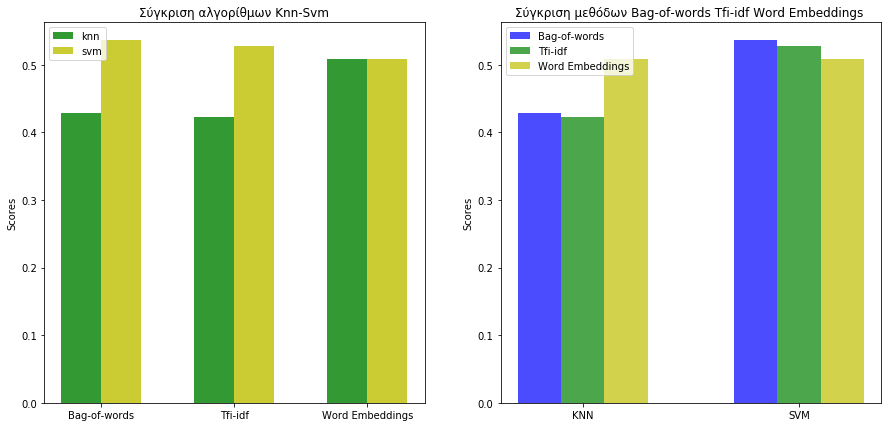

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
# n_groups =2
first_plot_a = (result_bag_knn, result_tfi_knn,result_emb_knn)
first_plot_b = (result_bag_svm, result_tfi_svm,result_emb_knn )

second_plot_a = (result_bag_knn, result_bag_svm)
second_plot_b = (result_tfi_knn, result_tfi_svm)
second_plot_c = (result_emb_knn, result_emb_knn)

# create plot
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,7))
# index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8



n_groups = 3
index = np.arange(n_groups)

rects1 = ax1.bar(index + bar_width, first_plot_a, bar_width,
alpha=opacity,
color='g',
label='knn')

rects2 = ax1.bar(index +bar_width + bar_width, first_plot_b, bar_width,
alpha=opacity,
color='y',
label='svm')

ax1.set_xlabel(' ')
ax1.set_ylabel('Scores')
ax1.set_title('Σύγκριση αλγορίθμων Knn-Svm')

ax1.set_xticks(index +bar_width + bar_width/2)
ax1.set_xticklabels( ('Bag-of-words', 'Tfi-idf', 'Word Embeddings'))

ax1.legend()

bar_width = 0.2
opacity = 0.7


n_groups =2
index = np.arange(n_groups)

rects1 = ax2.bar(index, second_plot_a, bar_width,
alpha=opacity,
color='b',
label='Bag-of-words')

rects2 = ax2.bar(index + bar_width, second_plot_b, bar_width,
alpha=opacity,
color='g',
label='Tfi-idf')

rects3 = ax2.bar(index +bar_width + bar_width, second_plot_c, bar_width,
alpha=opacity,
color='y',
label='Word Embeddings')

ax2.set_xlabel(' ')
ax2.set_ylabel('Scores')
ax2.set_title('Σύγκριση μεθόδων Bag-of-words Tfi-idf Word Embeddings ')

ax2.set_xticks(index + bar_width)
ax2.set_xticklabels( ('KNN', 'SVM'))


ax2.legend()

plt.show()